In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import datetime
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set(style='darkgrid', font_scale=1.4)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 1. Getting Data

In [2]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

train_test = pd.concat([train, test])

train_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# 2. Challenge Description
> PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
> 
> HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
> 
> CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
> Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
> Destination - The planet the passenger will be debarking to.
> Age - The age of the passenger.
> VIP - Whether the passenger has paid for special VIP service during the voyage.</font>
> RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
> Name - The first and last names of the passenger.

> **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# 3. Check Missing Values

In [3]:
print(train_test.isna().sum())

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64


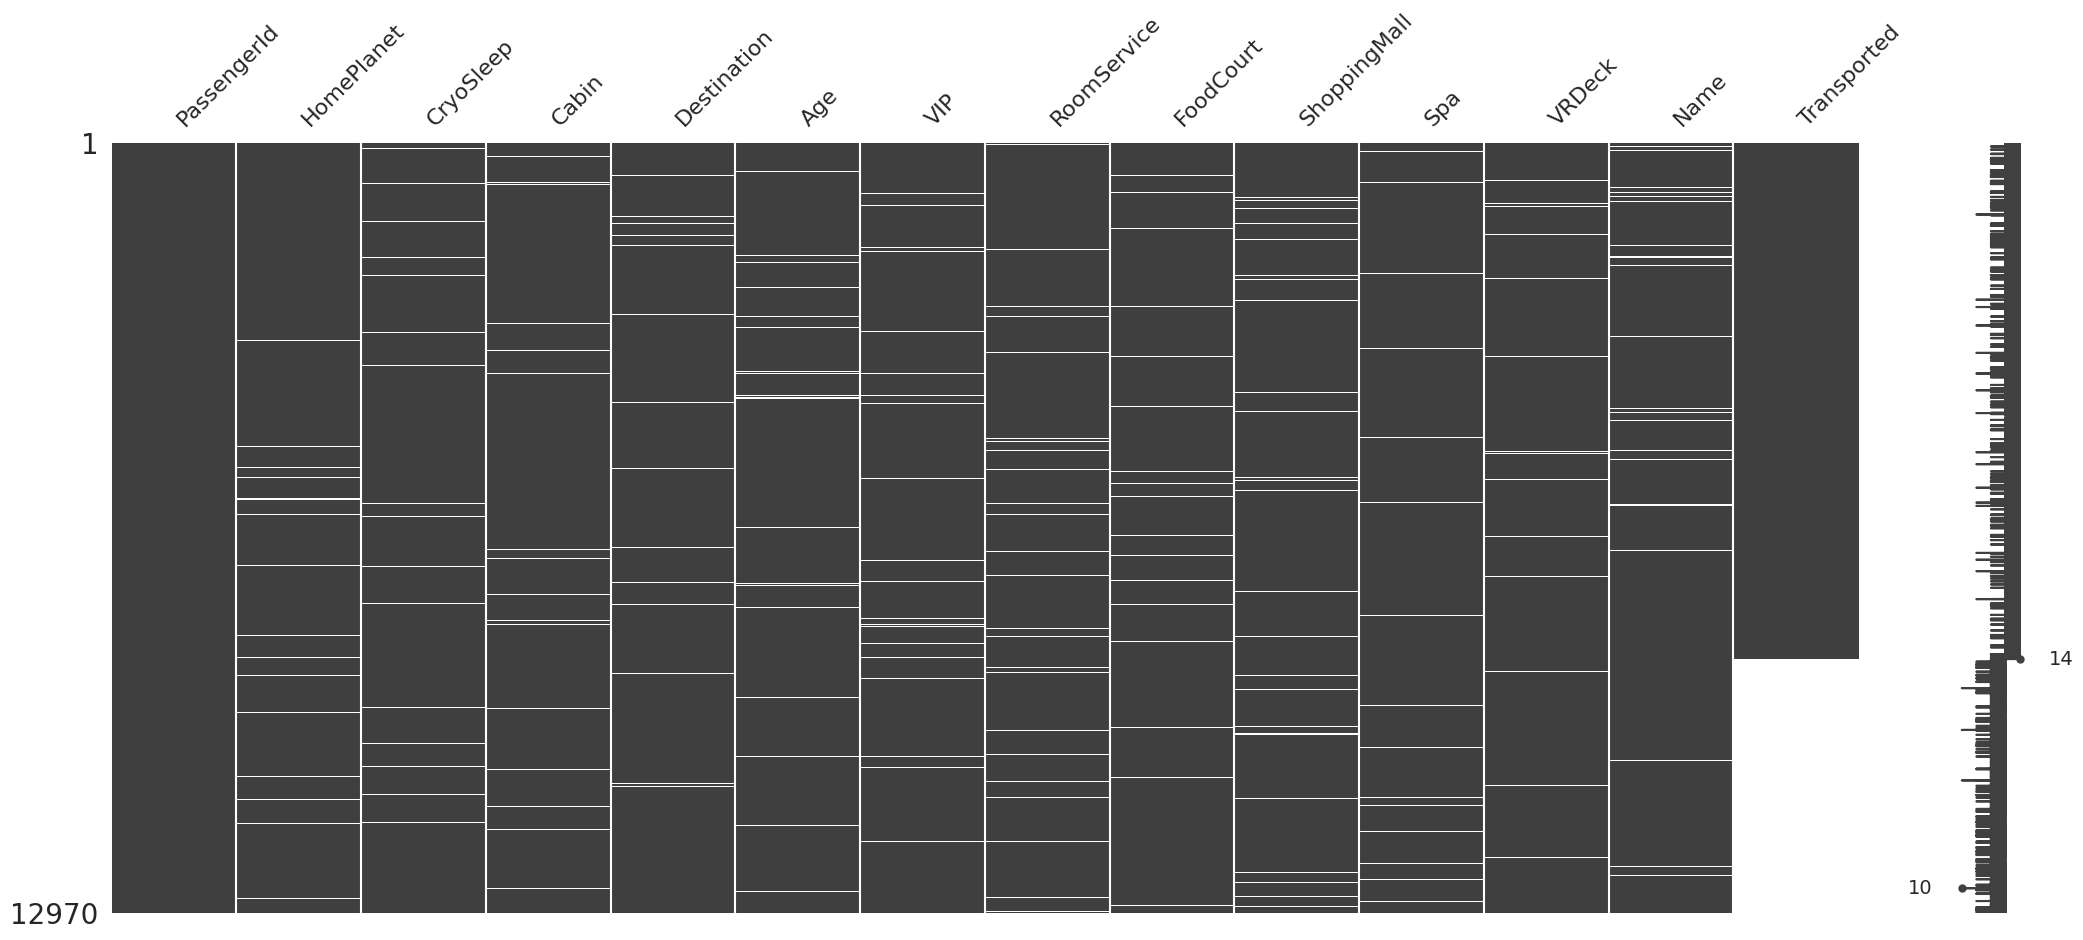

In [4]:
msno.matrix(train_test)
plt.show()

# 3. Testing & Handling Missing Values¶

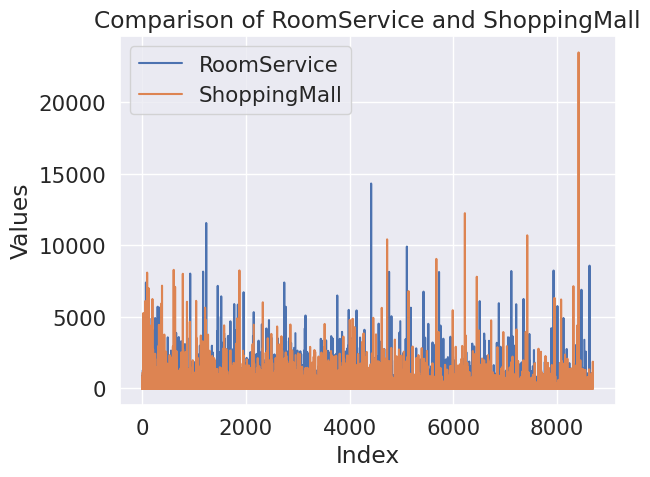

4277

In [5]:
# scatter_matrix(train_test, alpha=0.2, figsize=(6, 6), diagonal='kde')
# plt.show()
plt.plot(train_test['RoomService'], label='RoomService')
plt.plot(train_test['ShoppingMall'], label='ShoppingMall')
plt.title('Comparison of RoomService and ShoppingMall')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()
sum(train_test['Transported'].isna())

# 3.1.Handling Room Service Outliers

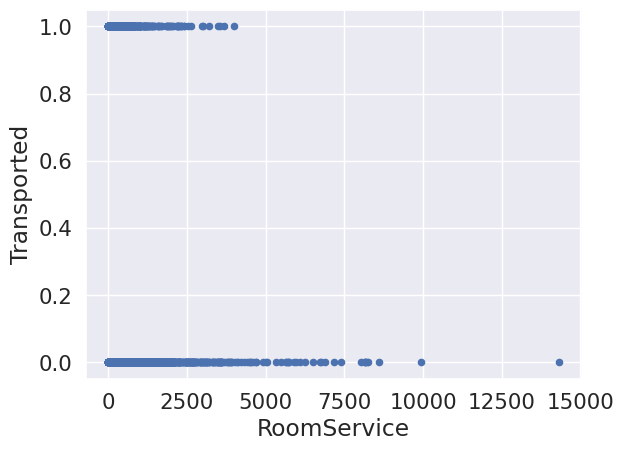

In [6]:
if 'Transported' in train_test.columns:
    train_test.plot.scatter(x='RoomService', y='Transported')
    plt.show()
else:
    print("'Transported' column does not exist in the DataFrame.")


In [7]:
# # scaled_value = (value - min) / (max - min)
# scaler = StandardScaler()
# # scaler = MinMaxScaler()
# train_test['RoomService'] = scaler.fit_transform(train_test[['RoomService']])
# train_test.plot.scatter(x='RoomService', y='Transported')
# plt.show()

In [8]:
# # How to delete instances using panda
# # Q1 = df['RoomService'].quantile(0.25)
# # Q3 = df['RoomService'].quantile(0.75)
# # IQR = Q3 - Q1
# # df = df[~((df['RoomService'] < (Q1 - 1.5 * IQR)) |(df['RoomService'] > (Q3 + 1.5 * IQR)))]



# indexNames1 = train_test[ (train_test['RoomService'] > 6000)& (train_test['Transported'] == False)].index
# indexNames2 = train_test[ (train_test['RoomService'] > 2850) & (train_test['Transported'] == True)].index
# train_test.drop(indexNames1 , inplace=True)
# train_test.drop(indexNames2 , inplace=True)


# train_test.plot.scatter(x='RoomService', y='Transported')
# plt.show()
# #df.info()
# # print(len(indexNames))

# 3.1.Handling Food Court Outliers

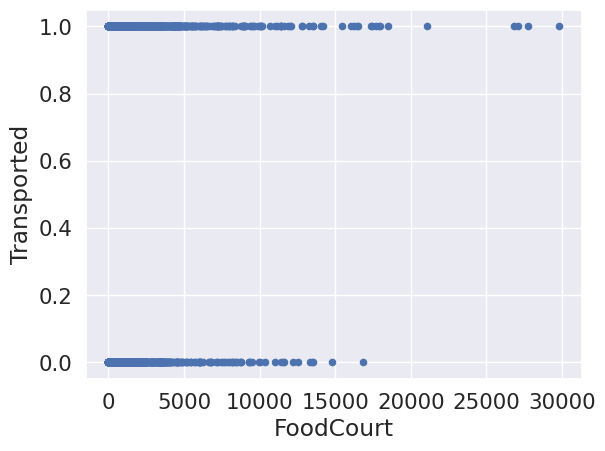

In [9]:
train_test.plot.scatter(x='FoodCourt', y='Transported')
plt.show()

In [10]:
# train_test['FoodCourt'] = scaler.fit_transform(train_test[['FoodCourt']])
# train_test.plot.scatter(x='FoodCourt', y='Transported')
# plt.show()

# 3.1.Handling ShoppingMall Outliers

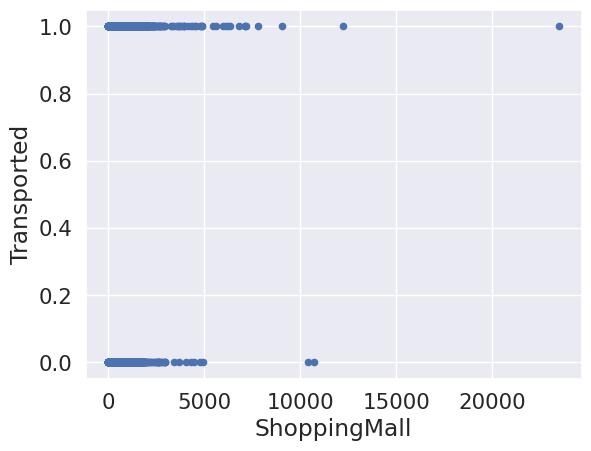

In [11]:
train_test.plot.scatter(x='ShoppingMall', y='Transported')
plt.show()

In [12]:
# train_test['ShoppingMall'] = scaler.fit_transform(train_test[['ShoppingMall']])
# train_test.plot.scatter(x='ShoppingMall', y='Transported')
# plt.show()

# 3.1.Handling Spa Outliers

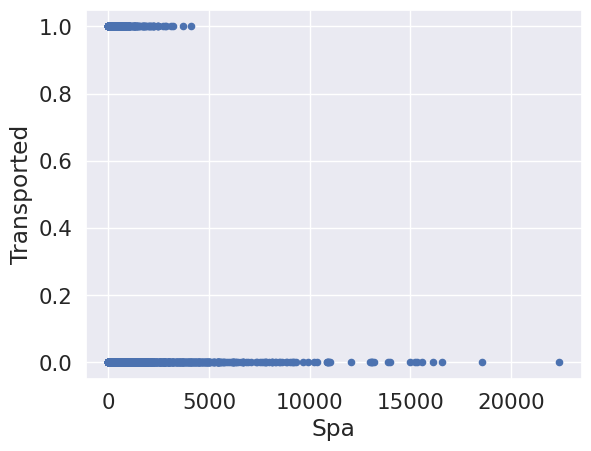

In [13]:
train_test.plot.scatter(x='Spa', y='Transported')
plt.show()

In [14]:
# train_test['Spa'] = scaler.fit_transform(train_test[['Spa']])
# train_test.plot.scatter(x='Spa', y='Transported')
# plt.show()

# 3.1.Handling VRDeck Outliers

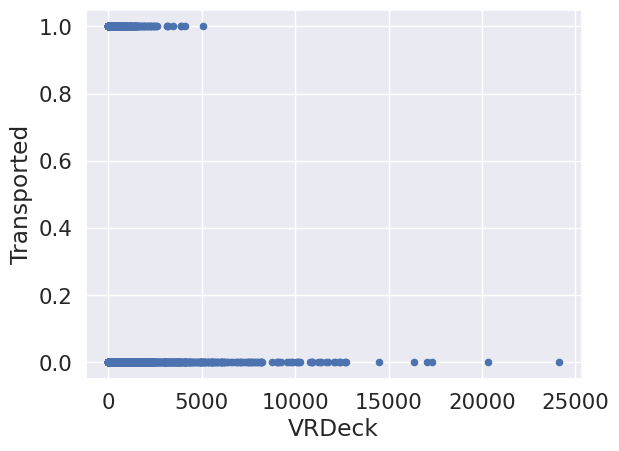

In [15]:
train_test.plot.scatter(x='VRDeck', y='Transported')
plt.show()

In [16]:
# train_test['VRDeck'] = scaler.fit_transform(train_test[['VRDeck']])
# train_test.plot.scatter(x='VRDeck', y='Transported')
# plt.show()

In [17]:
# mean = train_test['VRDeck'].mean()
# std = train_test['VRDeck'].std()
# ZScore = (train_test['VRDeck'] - mean) / std

# threshold = 3
# outliers = train_test[np.abs(ZScore) > threshold]
# outliers

In [18]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
#train_test.loc[(train_test['Age'] < 10) & (train_test[Expenses_columns].isnull()), Expenses_columns] = 0
# train_test.loc[(train_test['Age'] > 10) & train_test['RoomService'].isnull(), Expenses_columns] = train_test['RoomService'].mean()
# 


In [19]:
# First lets fill CryoSleep, based on totdal expenditure
train_test["Expenditure"]=train_test[Expenses_columns].sum(axis="columns")

# train_test.loc[train_test["Expenditure"] == 0 & train_test['Age'].isna(), 'Age'] = 0


# filling expenditure with use of Age
def fill_with_mean(row):
    for col in Expenses_columns:
        if row['Age'] > 12 and pd.isnull(row[col]):
            row[col] = train_test[col].mean()
    return row

train_test = train_test.apply(fill_with_mean, axis=1)



def fill_with_zero(row):
    for col in Expenses_columns:
        if row['Age'] < 12 and pd.isnull(row[col]):
            row[col] = 0
    return row

# train_test = train_test.apply(fill_with_zero, axis=1)



train_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12941 non-null  float64
 8   FoodCourt     12945 non-null  float64
 9   ShoppingMall  12937 non-null  float64
 10  Spa           12946 non-null  float64
 11  VRDeck        12927 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
 14  Expenditure   12970 non-null  float64
dtypes: float64(7), object(8)
memory usage: 1.6+ MB


In [20]:
# Thanks to @Master Jiraiya

# Zero expenditure indicate that they are in CryoSleep
train_test['CryoSleep']=np.where(train_test['Expenditure']==0,1,0)

# Also, if they are VIPs, they probably would not choose to be in CryoSleep
train_test['VIP']=np.where(train_test['CryoSleep']==0,1,0)

train_test.drop(columns=["Expenditure"],inplace=True)

print(train_test.isna().sum())

PassengerId        0
HomePlanet       288
CryoSleep          0
Cabin            299
Destination      274
Age              270
VIP                0
RoomService       29
FoodCourt         25
ShoppingMall      33
Spa               24
VRDeck            43
Name             294
Transported     4277
dtype: int64


In [21]:
train_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,1,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,1,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,1,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,1,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,1,G/1496/S,TRAPPIST-1e,34.0,0,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,0,NaN,TRAPPIST-1e,42.0,1,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,1,D/296/P,55 Cancri e,NaN,0,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,0,D/297/P,NaN,NaN,1,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


> HomePlanet: {'Earth', 'Europa', 'Mars', nan}
> {1,2,3,4}
> 
> #######################
> 
> Destination: {'55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', nan}
> {1,2,3,4}
> 
> 
> #######################
> 
> Cabin Class = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10}

In [22]:
#CryoSleep Train
train_test['CryoSleep'].replace({True: 1, False: 0}, inplace=True)

#Transported Train
train_test['Transported'] = train_test['Transported'].replace({True: 1, False: 0})

#HomePlanet Train
train_test['HomePlanet'].replace('Earth', 1, inplace=True)
train_test['HomePlanet'].replace('Europa', 2, inplace=True)
train_test['HomePlanet'].replace('Mars', 3, inplace=True)

#Destination Train
train_test['Destination'].replace('55 Cancri e', 1, inplace=True)
train_test['Destination'].replace('PSO J318.5-22', 2, inplace=True)
train_test['Destination'].replace('TRAPPIST-1e', 3, inplace=True)


#Vip Train
train_test['VIP'].replace({True: 1, False: 0}, inplace=True)


########################################################


# #CryoSleep Test
# test['CryoSleep'].replace({True: 1, False: 0}, inplace=True)

# #Transported Test
# # Don't have transported

# #HomePlanet Test
# test['HomePlanet'].replace('Earth', 1, inplace=True)
# test['HomePlanet'].replace('Europa', 2, inplace=True)
# test['HomePlanet'].replace('Mars', 3, inplace=True)

# #Destination Test
# test['Destination'].replace('55 Cancri e', 1, inplace=True)
# test['Destination'].replace('PSO J318.5-22', 2, inplace=True)
# test['Destination'].replace('TRAPPIST-1e', 3, inplace=True)

# #Vip Test
# test['VIP'].replace({True: 1, False: 0}, inplace=True)


train_test
# train_test.info()
# test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,2.0,1,B/0/P,3.0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0
1,0002_01,1.0,0,F/0/S,3.0,24.0,1,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0
2,0003_01,2.0,0,A/0/S,3.0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0
3,0003_02,2.0,0,A/0/S,3.0,33.0,1,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0
4,0004_01,1.0,0,F/1/S,3.0,16.0,1,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,1.0,1,G/1496/S,3.0,34.0,0,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,1.0,0,NaN,3.0,42.0,1,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,3.0,1,D/296/P,1.0,NaN,0,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,2.0,0,D/297/P,NaN,NaN,1,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [23]:
# expenses_grouped = train_test.groupby('Transported')[Expenses_columns].mean()

# plt.figure(figsize=(12, 6))
# expenses_grouped.plot(kind='bar')
# plt.xlabel('Transported')
# plt.ylabel('Average Expenses')
# plt.title('Average Expenses by Transported')
# plt.legend(Expenses_columns)
# plt.show()
sum(train_test["Age"].isna())

270

# 4. Filling NaN and Null cells

In [24]:
#Data For Train_Test
train_test["Name"].fillna("Unknown Unknown",inplace=True)
train_test["HomePlanet"].fillna(train_test["HomePlanet"].mode()[0],inplace=True)
train_test["Destination"].fillna(train_test["Destination"].mode()[0],inplace=True)
train_test["Cabin"].fillna(train_test["Cabin"].mode()[0],inplace=True)
train_test["Age"].fillna(int(train_test["Age"].mean()),inplace=True)
train_test["RoomService"].fillna(train_test["RoomService"].mean(),inplace=True)
train_test["FoodCourt"].fillna(train_test["FoodCourt"].mean(),inplace=True)
train_test["ShoppingMall"].fillna(train_test["ShoppingMall"].mean(),inplace=True)
train_test["Spa"].fillna(train_test["Spa"].mean(),inplace=True)
train_test["VRDeck"].fillna(train_test["VRDeck"].mean(),inplace=True)

# Define the bins and labels for AGE column
bins = [0, 15, 25, 35, 45, 60, 75, 90,120, 150]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Use pd.cut to scale the 'Age' column
train_test['Age'] = pd.cut(train_test['Age'], bins=bins, labels=labels, right=False)
# test['Age'] = pd.cut(test['Age'], bins=bins, labels=labels, right=False)




#No Nan, Null or empty cell
print(train_test.isna().sum())

PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name               0
Transported     4277
dtype: int64


In [25]:
train_test[['Deck', 'Cabin', 'Port']] = train_test['Cabin'].str.split('/', expand=True)

# Train Data
#Port or Starboard of the cabins
train_test['Port'].replace('S', 0, inplace=True)
train_test['Port'].replace('P', 1, inplace=True)

#Class of the cabins
letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
train_test['Deck'] = train_test['Deck'].map(letter_to_int)


#####################################
#####################################
#####################################

# Test Data

# #Port or Starboard of the cabins
# test['Port'] = test['Cabin'].str.split('/').str[-1]
# test['Port'].replace('S', 0, inplace=True)
# test['Port'].replace('P', 1, inplace=True)

# #Class of the cabins
# test['Place'] = test['Cabin'].str.split('/').str[0]
# letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
# test['Place'] = test['Place'].map(letter_to_int)


# #Number of cabins
# test['Cabin'] = test['Cabin'].str.split('/').str[1]



train_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Port
0,0001_01,2.0,1,0,3.0,4,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,2,1
1,0002_01,1.0,0,0,3.0,2,1,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,6,0
2,0003_01,2.0,0,0,3.0,5,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,1,0


In [26]:
train_test['Group'] = train_test['PassengerId'].astype(str).str[:4]
train_test['Name'] = train_test['Name'].str.split().str[-1]
train_test['FamilyGroupID'] = train_test['Name'] + '_' + train_test['Group']
train_test['FamilyGroupID'] = train_test.groupby('FamilyGroupID').ngroup()

train_test['FamilyID'] = pd.factorize(train_test['FamilyGroupID'])[0]
train_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Port,Group,FamilyGroupID,FamilyID
0,0001_01,2.0,1,0,3.0,4,0,0.0,0.0,0.0,0.0,0.0,Ofracculy,0.0,2,1,0001,6305,0
1,0002_01,1.0,0,0,3.0,2,1,109.0,9.0,25.0,549.0,44.0,Vines,1.0,6,0,0002,9276,1
2,0003_01,2.0,0,0,3.0,5,1,43.0,3576.0,0.0,6715.0,49.0,Susent,0.0,1,0,0003,8502,2
3,0003_02,2.0,0,0,3.0,3,1,0.0,1283.0,371.0,3329.0,193.0,Susent,0.0,1,0,0003,8502,2
4,0004_01,1.0,0,1,3.0,2,1,303.0,70.0,151.0,565.0,2.0,Santantines,1.0,6,0,0004,7685,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,1.0,1,1496,3.0,3,0,0.0,0.0,0.0,0.0,0.0,Peter,NaN,7,0,9266,6676,9822
4273,9269_01,1.0,0,160,3.0,4,1,0.0,847.0,17.0,10.0,144.0,Scheron,NaN,7,1,9269,7753,9823
4274,9271_01,3.0,1,296,1.0,3,0,0.0,0.0,0.0,0.0,0.0,Pore,NaN,4,1,9271,6868,9824
4275,9273_01,2.0,0,297,3.0,3,1,0.0,2680.0,0.0,0.0,523.0,Conale,NaN,4,1,9273,1990,9825


In [27]:
# train_test['Group'] = train_test['PassengerId'].astype(str).str[:4]
# counts = train_test['Group'].value_counts()
# train_test['Group'] = train_test['Group'].map(counts)
# train_test.info()

In [28]:
train_test[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'Port', 'Deck','Group']]= train_test[['HomePlanet', 'CryoSleep','Cabin', 'Destination', 'Age', 'VIP', 'Port', 'Deck','Group']].astype('Int64')
# train_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]= train_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].astype('Int64')
train_test[['Transported']]= train_test[['Transported']].astype('Int64')

train_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    12970 non-null  object 
 1   HomePlanet     12970 non-null  Int64  
 2   CryoSleep      12970 non-null  Int64  
 3   Cabin          12970 non-null  Int64  
 4   Destination    12970 non-null  Int64  
 5   Age            12970 non-null  Int64  
 6   VIP            12970 non-null  Int64  
 7   RoomService    12970 non-null  float64
 8   FoodCourt      12970 non-null  float64
 9   ShoppingMall   12970 non-null  float64
 10  Spa            12970 non-null  float64
 11  VRDeck         12970 non-null  float64
 12  Name           12970 non-null  object 
 13  Transported    8693 non-null   Int64  
 14  Deck           12970 non-null  Int64  
 15  Port           12970 non-null  Int64  
 16  Group          12970 non-null  Int64  
 17  FamilyGroupID  12970 non-null  int64  
 18  FamilyID    

In [29]:
##Apply square root transformation

## Train Data
train_test['RoomService'] = train_test['RoomService']**0.5
train_test['FoodCourt'] = train_test['FoodCourt']**0.5
train_test['ShoppingMall'] = train_test['ShoppingMall']**0.5
train_test['Spa'] = train_test['Spa']**0.5
train_test['VRDeck'] = train_test['VRDeck']**0.5


# ## Test Data
# test['RoomService'] = test['RoomService']**0.5
# test['FoodCourt'] = test['FoodCourt']**0.5
# test['ShoppingMall'] = test['ShoppingMall']**0.5
# test['Spa'] = test['Spa']**0.5
# test['VRDeck'] = test['VRDeck']**0.5

# train_test.head(3)
print(train_test.isna().sum())

PassengerId         0
HomePlanet          0
CryoSleep           0
Cabin               0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name                0
Transported      4277
Deck                0
Port                0
Group               0
FamilyGroupID       0
FamilyID            0
dtype: int64


In [30]:
# ## Apply log transformation

# ## Train Data
# train['RoomService'] = np.log1p(train['RoomService'])
# train['FoodCourt'] = np.log1p(train['FoodCourt'])
# train['ShoppingMall'] = np.log1p(train['ShoppingMall'])
# train['Spa'] = np.log1p(train['Spa'])
# train['VRDeck'] = np.log1p(train['VRDeck'])


# ## Test Data
# test['RoomService'] = np.log1p(test['RoomService'])
# test['FoodCourt'] = np.log1p(test['FoodCourt'])
# test['ShoppingMall'] = np.log1p(test['ShoppingMall'])
# test['Spa'] = np.log1p(test['Spa'])
# test['VRDeck'] = np.log1p(test['VRDeck'])
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    12970 non-null  object 
 1   HomePlanet     12970 non-null  Int64  
 2   CryoSleep      12970 non-null  Int64  
 3   Cabin          12970 non-null  Int64  
 4   Destination    12970 non-null  Int64  
 5   Age            12970 non-null  Int64  
 6   VIP            12970 non-null  Int64  
 7   RoomService    12970 non-null  float64
 8   FoodCourt      12970 non-null  float64
 9   ShoppingMall   12970 non-null  float64
 10  Spa            12970 non-null  float64
 11  VRDeck         12970 non-null  float64
 12  Name           12970 non-null  object 
 13  Transported    8693 non-null   Int64  
 14  Deck           12970 non-null  Int64  
 15  Port           12970 non-null  Int64  
 16  Group          12970 non-null  Int64  
 17  FamilyGroupID  12970 non-null  int64  
 18  FamilyID    

<Axes: >

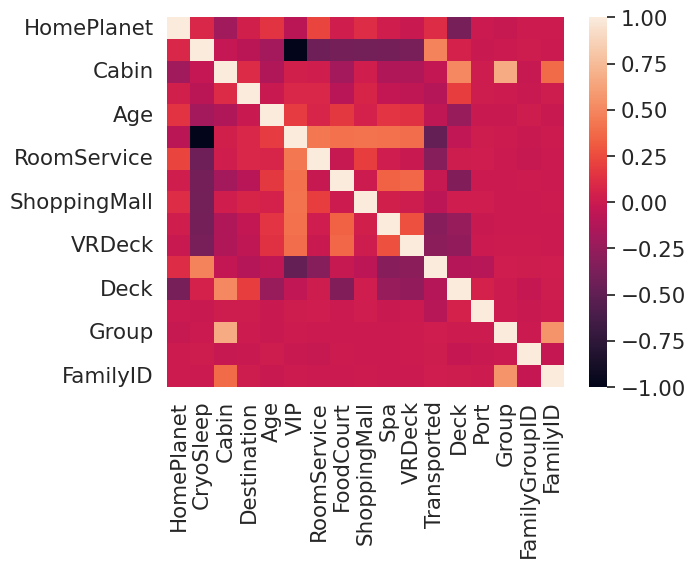

In [31]:
train_num = train_test.select_dtypes(include=['float64', 'int64'])

# Calculate the correlations of numerical columns
corr = train_num.corr()

sns.heatmap(corr, annot=False)

In [32]:
#print('cryo Taransported: ', sum(df[df.CryoSleep == 1].Transported), 'transported: ',sum(df.Transported))
# # Calculate mean
# df['Mean_luxury'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1)

# df = df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

# df['BigSpender'] = np.where(df.Mean_luxury > 1000, 1,0)
# df['Mid_Spender'] = np.where(df.Mean_luxury >= 500, 1,0)
# df['Non_Spender'] = np.where(df.Mean_luxury == 0, 1,0)
# df.head(3)

{1:'55 Cancri e', 2:'PSO J318.5-22', 3:'TRAPPIST-1e'}
{1:'Earth', 2:'Europa', 3:'Mars'}
<<<<<HomePlanet to Destination>>>>
1 to 1 >>> 721
1 to 2 >>> 728
1 to 3 >>> 3354
--------------    
2 to 1 >>> 193
2 to 2 >>> 49
2 to 3 >>> 1517
-------------- 
3 to 1 >>> 886
3 to 2 >>> 19
3 to 3 >>> 1226
-------------- 

In [33]:
train = train_test[train_test['Transported'].notnull()].copy()
train.Transported =train.Transported.astype('Int64')
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0 to 4276
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    4277 non-null   object 
 1   HomePlanet     4277 non-null   Int64  
 2   CryoSleep      4277 non-null   Int64  
 3   Cabin          4277 non-null   Int64  
 4   Destination    4277 non-null   Int64  
 5   Age            4277 non-null   Int64  
 6   VIP            4277 non-null   Int64  
 7   RoomService    4277 non-null   float64
 8   FoodCourt      4277 non-null   float64
 9   ShoppingMall   4277 non-null   float64
 10  Spa            4277 non-null   float64
 11  VRDeck         4277 non-null   float64
 12  Name           4277 non-null   object 
 13  Deck           4277 non-null   Int64  
 14  Port           4277 non-null   Int64  
 15  Group          4277 non-null   Int64  
 16  FamilyGroupID  4277 non-null   int64  
 17  FamilyID       4277 non-null   int64  
dtypes: Int64(9), 

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    8693 non-null   object 
 1   HomePlanet     8693 non-null   Int64  
 2   CryoSleep      8693 non-null   Int64  
 3   Cabin          8693 non-null   Int64  
 4   Destination    8693 non-null   Int64  
 5   Age            8693 non-null   Int64  
 6   VIP            8693 non-null   Int64  
 7   RoomService    8693 non-null   float64
 8   FoodCourt      8693 non-null   float64
 9   ShoppingMall   8693 non-null   float64
 10  Spa            8693 non-null   float64
 11  VRDeck         8693 non-null   float64
 12  Name           8693 non-null   object 
 13  Transported    8693 non-null   Int64  
 14  Deck           8693 non-null   Int64  
 15  Port           8693 non-null   Int64  
 16  Group          8693 non-null   Int64  
 17  FamilyGroupID  8693 non-null   int64  
 18  FamilyID     

In [35]:
### Train Data
newTrain = train
train_ids = newTrain['PassengerId'].copy()
train_trs = newTrain['Transported'].copy()
newTrain.drop(columns=['PassengerId','Name','Transported'],inplace=True)


#####################


### Test Data
newTest = test
test_ids = newTest['PassengerId'].copy()
newTest.drop(columns=['PassengerId','Name'],inplace=True)


newTrain.head(3)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Port,Group,FamilyGroupID,FamilyID
0,2,1,0,3,4,0,0.000000,0.000000,0.0,0.000000,0.00000,2,1,1,6305,0
1,1,0,0,3,2,1,10.440307,3.000000,5.0,23.430749,6.63325,6,0,2,9276,1
2,2,0,0,3,5,1,6.557439,59.799666,0.0,81.945104,7.00000,1,0,3,8502,2


In [36]:
newTrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   Int64  
 1   CryoSleep      8693 non-null   Int64  
 2   Cabin          8693 non-null   Int64  
 3   Destination    8693 non-null   Int64  
 4   Age            8693 non-null   Int64  
 5   VIP            8693 non-null   Int64  
 6   RoomService    8693 non-null   float64
 7   FoodCourt      8693 non-null   float64
 8   ShoppingMall   8693 non-null   float64
 9   Spa            8693 non-null   float64
 10  VRDeck         8693 non-null   float64
 11  Deck           8693 non-null   Int64  
 12  Port           8693 non-null   Int64  
 13  Group          8693 non-null   Int64  
 14  FamilyGroupID  8693 non-null   int64  
 15  FamilyID       8693 non-null   int64  
dtypes: Int64(9), float64(5), int64(2)
memory usage: 1.2 MB


In [37]:
newTest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     4277 non-null   Int64  
 1   CryoSleep      4277 non-null   Int64  
 2   Cabin          4277 non-null   Int64  
 3   Destination    4277 non-null   Int64  
 4   Age            4277 non-null   Int64  
 5   VIP            4277 non-null   Int64  
 6   RoomService    4277 non-null   float64
 7   FoodCourt      4277 non-null   float64
 8   ShoppingMall   4277 non-null   float64
 9   Spa            4277 non-null   float64
 10  VRDeck         4277 non-null   float64
 11  Deck           4277 non-null   Int64  
 12  Port           4277 non-null   Int64  
 13  Group          4277 non-null   Int64  
 14  FamilyGroupID  4277 non-null   int64  
 15  FamilyID       4277 non-null   int64  
dtypes: Int64(9), float64(5), int64(2)
memory usage: 605.6 KB


In [38]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(newtrainDF.drop('Transported',axis=1), 
#                                                   df['Transported'], test_size=0.30, 
#                                                     random_state=101)
# newtrainDF.head(1)

In [39]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(newTrain, train_trs)

LogisticRegression(max_iter=10000)

In [40]:
# df_test['stSpenders'] = df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].std(axis=1)
# df_test = df_test.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
# df_test.head()

In [41]:
 predictions = logmodel.predict(newTest)

In [42]:
df_predictions = pd.DataFrame()
df_predictions['PassengerId'] = pd.Series(test_ids.T.values)
df_predictions['Transported'] = pd.Series(predictions)
df_predictions.Transported = np.where(df_predictions.Transported==1,True,False)
df_predictions.to_csv("21thAttempt.csv", sep=',', index=False)
df_predictions.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,True
2,0019_01,True
3,0021_01,True
4,0023_01,True


In this report, the 'Precision' column tells us the proportion of positive identifications (i.e., the passenger was transported) that were actually correct. The 'Recall' column tells us the proportion of actual positives that were identified correctly. The 'F1-score' is a function of Precision and Recall and gives a balanced measure of the model's performance.

Remember, this is a basic model. Depending on the performance of the model, you might need to consider more advanced techniques such as handling class imbalance, feature engineering, or using a more complex model.